# Вступление

В этом ноутбуке представлен маршрут по кластеризации изображений. Получив большой набор изображений с неопределённым числом  классов наиболее оптимальным вариантом разбиения представляется кластеризация - разбение изображений на группы в соответствии с их визуальной схожестью.

В качестве основного метода кластеризации был использован K-Means. Оптимальное число кластеров подбиралось методом локтя.

В качестве признаков использовалась как обычная "интенсивность" изображения(значение пикселя 0-256), так и карты признаков извлечённые AlexNet из всего архива картинок.

**Спойлер:** данный подход не увенчался успехом, и пришлось смотреть все картинки вручную:) Данные снимки дефектов действительно очень похожи, и требуют внимательной разметки специалиста. Тем не менее, при работе с другими изображениями этот подход может оказаться довольно полезным и показать лучший результат.  


Подход в данной работе был позаимствован [отсюда](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34).

# Импортируем библиотеки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import os
import sys
import random
import copy
import time
import shutil
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from pandas import DataFrame
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn import preprocessing
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix





def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(42)

In [ ]:
!unzip /content/drive/MyDrive/datasets/orig_cropped_defects.zip

In [4]:
%cd /content/orig_cropped_defects

/content/orig_cropped_defects


In [5]:
import os
import glob as glob

path = '/content/orig_cropped_defects'


defects_list = glob.glob(f"{path}/*.jpg")
#defects_list = os.listdir(path)

len(defects_list)

8415

In [6]:
assert len(set(defects_list)) == len(defects_list)

In [7]:
data_transforms =  transforms.Compose([
        transforms.Resize(size=(64,64)),
        transforms.ToTensor(),
    ])

# K-Means, где в качестве признаков используется значение пикселя

Посмотрим на картинки

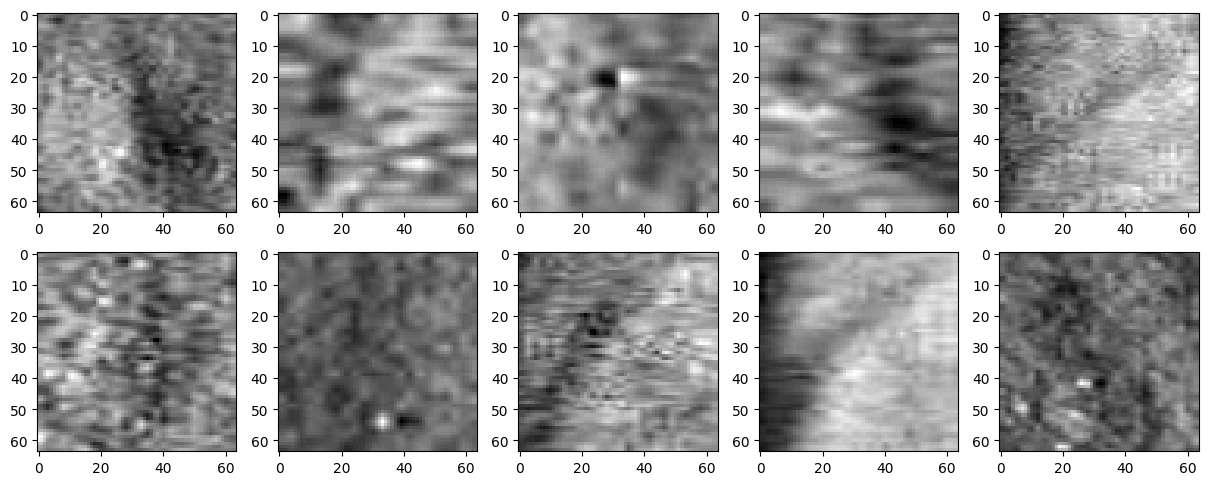

In [9]:
from PIL import Image
import numpy

random_sample = random.sample(defects_list, 10)

plt.figure(figsize= (15,15))
for i,image_path in enumerate(random_sample):

  img= Image.open(image_path)

  img = data_transforms(img)

  plt.subplot(5,5, i + 1)
  plt.imshow(img.permute(1, 2, 0), cmap='gray')


На этом этапе я для себя увидел примерно 3 группы картинок, которые визуально похожи друг на друга.

In [10]:
defects_list.sort()

Преобразуем все картинки в вектор размером **64x64**. Создадим словарик, где ключами будут ID картинок, а значениями - соответствующая векторная форма изображения.

In [11]:
data_dict = {}

def preprocess_dataset(defect_images: list) -> None:

  for defect_name in defect_images:

    IMG_ID = defect_name.split('/')[-1].split('.')[0]

    img = Image.open(os.path.join(path, defect_name))
    feature_vector = data_transforms(img)

    data_dict[IMG_ID] = feature_vector

preprocess_dataset(defect_images=defects_list)
#print(data_dict)



Проверим размерность

In [12]:
features_matrix = np.array(list(data_dict.values())).reshape(-1, 64  * 64)


assert (len(defects_list), 64 * 64) == features_matrix.shape


Применим метод главным компонент, чтобы оставить наиболее информативные признаки. Сократим количество признаков до 3-ёх для возможности визуализации в пространстве:

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


pca = PCA(n_components = 3, random_state=42)

X_pca = pca.fit_transform(features_matrix)

In [14]:
print(f"Components before PCA: {features_matrix.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 3


Представим полученную матрицу признаков в виде датафрейма, где в каждой строке отображаются значения признаков для одного изображения:

In [15]:
#feature_dataframe = pd.DataFrame(X_pca)
column_names = ['feature1', 'feature2', 'feature3']

feature_df = pd.DataFrame(X_pca, columns = column_names)
feature_df.head(10)

,feature1,feature2,feature3
0,3.050567,-1.759067,-0.773679
1,1.602584,-0.212809,0.254288
2,-0.470113,0.324121,0.429137
3,1.547649,-0.091189,-0.127566
4,-0.879483,-0.599596,0.413111
5,-1.464350,0.522490,0.189251
6,-1.737879,0.161103,-0.316207
7,1.676422,-0.637547,0.034811
8,1.774930,0.617231,-0.392938
9,1.388651,-0.128268,0.300324


Визуализируем точки в пространстве:

In [16]:
import plotly.express as px

fig = px.scatter_3d(feature_df,
                    x = 'feature1',
                    y = 'feature2',
                    z = 'feature3')
fig.update_layout(margin = dict(t = 20, b = 10, l = 10, r = 10), scene = dict(aspectmode = 'data'))

fig.show()

Применим метод локтя для определения оптимального числа кластеров:

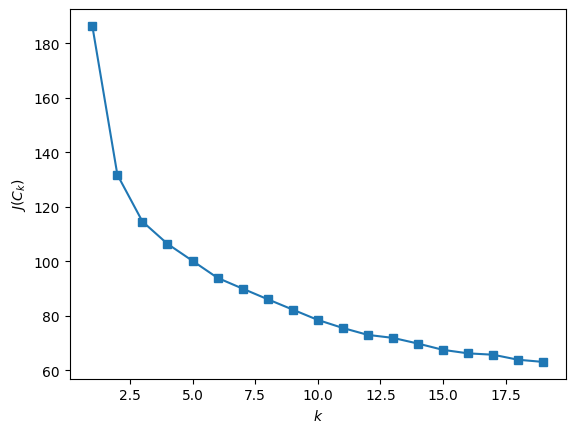

In [17]:
from sklearn import metrics
from scipy.spatial.distance import cdist

rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Наиболее оптимальным вариантом представляется выбрать число кластеров равное 3. Проведём кластеризация с данным числом кластеров:

In [18]:
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 10).fit(X_pca)

clusters = kmeans.predict(X_pca)
clustered_df = pd.DataFrame(data = np.hstack((X_pca, clusters.reshape(-1,1))),
                            columns = ['feature1','feature2','feature3','cluster_number'],
                            index = list(map(int ,list(data_dict.keys()))))


Визуализируем разбиение:

In [19]:
color_scale = px.colors.sequential.Plasma

fig_cl = px.scatter_3d(clustered_df,
                    x = 'feature1',
                    y = 'feature2',
                    z = 'feature3',
                    color = 'cluster_number',
                    color_continuous_scale = color_scale)

fig_cl.update_layout(margin = dict(t = 20, b = 10, l = 10, r = 10), scene = dict(aspectmode = 'data'))

fig_cl.show()

Теперь посмотрим, какие как разибились наши изображения на кластеры:

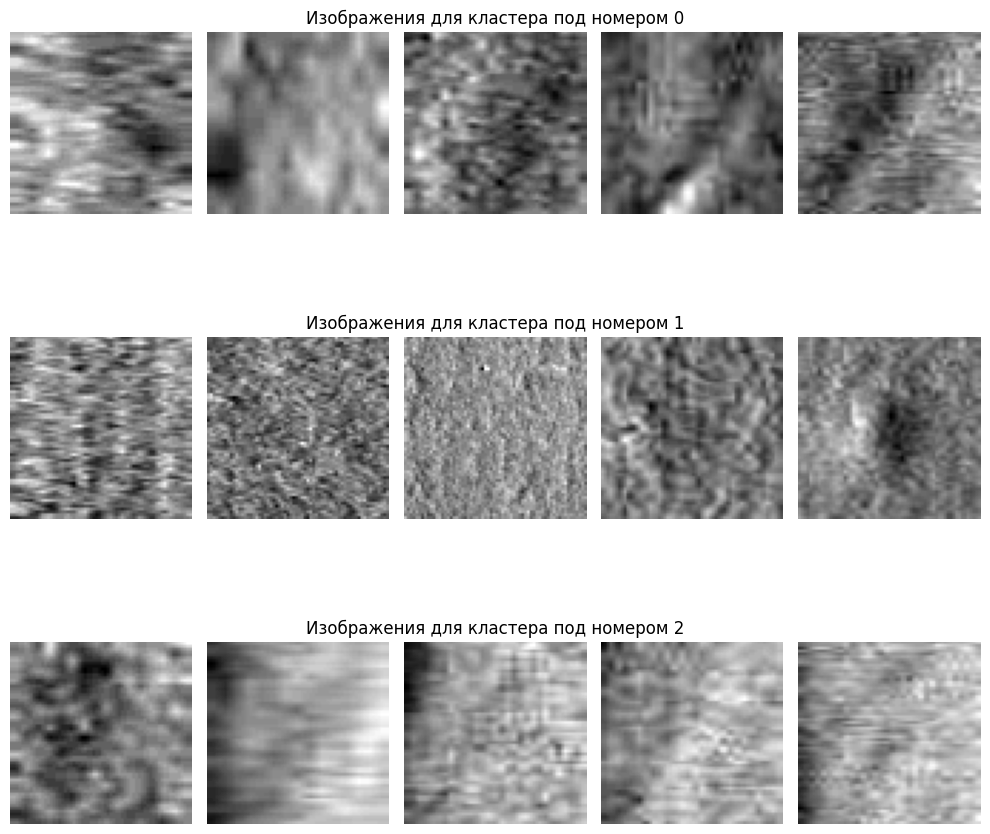

In [20]:
n_clusters = 3

num_images_per_cluster = 5

fig, axis = plt.subplots(n_clusters, num_images_per_cluster, figsize = (10,10))

for cluster in range(n_clusters):
  cluster_indices = list(clustered_df[clustered_df['cluster_number'] == cluster].sample(5).index)

  #print(f'Изображения для кластера под номером {cluster}')
  for i, image_index in enumerate(cluster_indices):
    ax = axis[cluster, i]

    image_path = os.path.join(path, str(image_index)+ '.jpg')
    image = Image.open(image_path)
    image = data_transforms(image)


    ax.imshow(image.permute(1,2,0), cmap = 'gray')
    ax.axis('off')

  axis[cluster, 2].title.set_text(f'Изображения для кластера под номером {cluster}')
#plt.subtitle('В каждой строке изображения из одного кластера')
plt.tight_layout()

plt.show()



## Вывод:

Картинки плохо разбиваются на кластеры. Все кластеры очень похожи между собой.Группы картинок, которые можно было бы выделить даже при беглом просмотре изображений не были выделены.

# K-means, где в качестве признаков используются извлечённые AlexNet feature-map(ы)

Загружаем AlexNet

In [ ]:
#from torch.summary import summary

model = models.alexnet(pretrained = True)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Убираем два последних слоя:

In [ ]:
drop_last_two = list(model.classifier.children())[:-2]

In [ ]:
model.classifier = nn.Sequential(*drop_last_two)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
new_data_transforms =  transforms.Compose([
        transforms.Resize(size=(64,64)),
        transforms.ToTensor(),
    ])

Подгрузим картинку. Сделаем пробное предсказание на одной картинке и посмотрим на размерность выходного тензора:

In [ ]:
input_image = Image.open('/content/orig_cropped_defects/3263826876.jpg').convert('RGB')

input_tensor = new_data_transforms(input_image)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

In [ ]:
output.shape

torch.Size([1, 4096])

(ячейка ниже выполняется довольно долго)

In [ ]:
from PIL import Image

new_data_dict = {}

def preprocess_dataset(defect_images: list) -> None:

  for defect_name in defect_images:

    IMG_ID = defect_name.split('/')[-1].split('.')[0]

    input_image = Image.open(os.path.join(path, defect_name)).convert('RGB')
    input_tensor = new_data_transforms(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
      output = model(input_batch)

    new_data_dict[IMG_ID] = output

preprocess_dataset(defect_images=defects_list)
#print(data_dict)



In [ ]:
feature_matrix = np.array(list(new_data_dict.values())).squeeze()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


pca = PCA(n_components = 3, random_state=42)

X_pca = pca.fit_transform(feature_matrix)

In [ ]:
print(f"Components before PCA: {feature_matrix.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 3


In [ ]:
column_names = ['feature1', 'feature2', 'feature3', 'feature4']

feature_df = pd.DataFrame(X_pca, columns = column_names)
feature_df.head(10)

,feature1,feature2,feature3
0,16.451437,42.977669,-11.136489
1,15.365191,-5.178213,25.299631
2,-28.610527,-11.869902,22.168154
3,-3.848222,78.481171,11.114178
4,4.733252,44.668808,-22.747332
5,-75.710915,-7.746049,6.250267
6,4.793475,-37.634457,41.916893
7,16.295910,28.008009,-22.516748
8,-26.851753,37.069477,40.607830
9,14.589502,4.925014,58.696152


In [ ]:
import plotly.express as px

fig = px.scatter_3d(feature_df,
                    x = 'feature1',
                    y = 'feature2',
                    z = 'feature3')
fig.update_layout(margin = dict(t = 20, b = 10, l = 10, r = 10), scene = dict(aspectmode = 'data'))

fig.show()

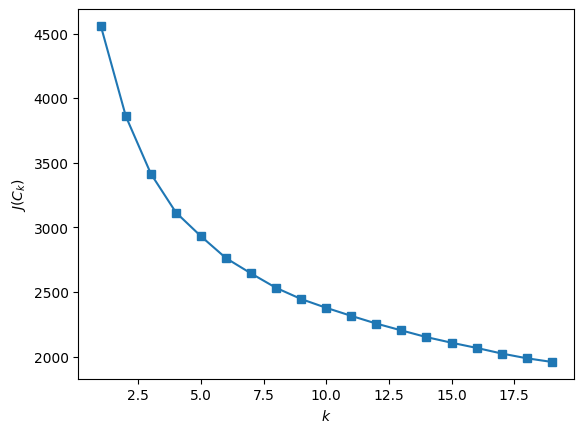

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 10).fit(X_pca)

clusters = kmeans.predict(X_pca)
clustered_df = pd.DataFrame(data = np.hstack((X_pca, clusters.reshape(-1,1))),
                            columns = ['feature1','feature2','feature3','cluster_number'],
                            index = list(map(int ,list(new_data_dict.keys()))))


In [ ]:
color_scale = px.colors.sequential.Plasma

fig_cl = px.scatter_3d(clustered_df,
                    x = 'feature1',
                    y = 'feature2',
                    z = 'feature3',
                    color = 'cluster_number',
                    color_continuous_scale = color_scale)

fig_cl.update_layout(margin = dict(t = 20, b = 10, l = 10, r = 10), scene = dict(aspectmode = 'data'))

fig_cl.show()

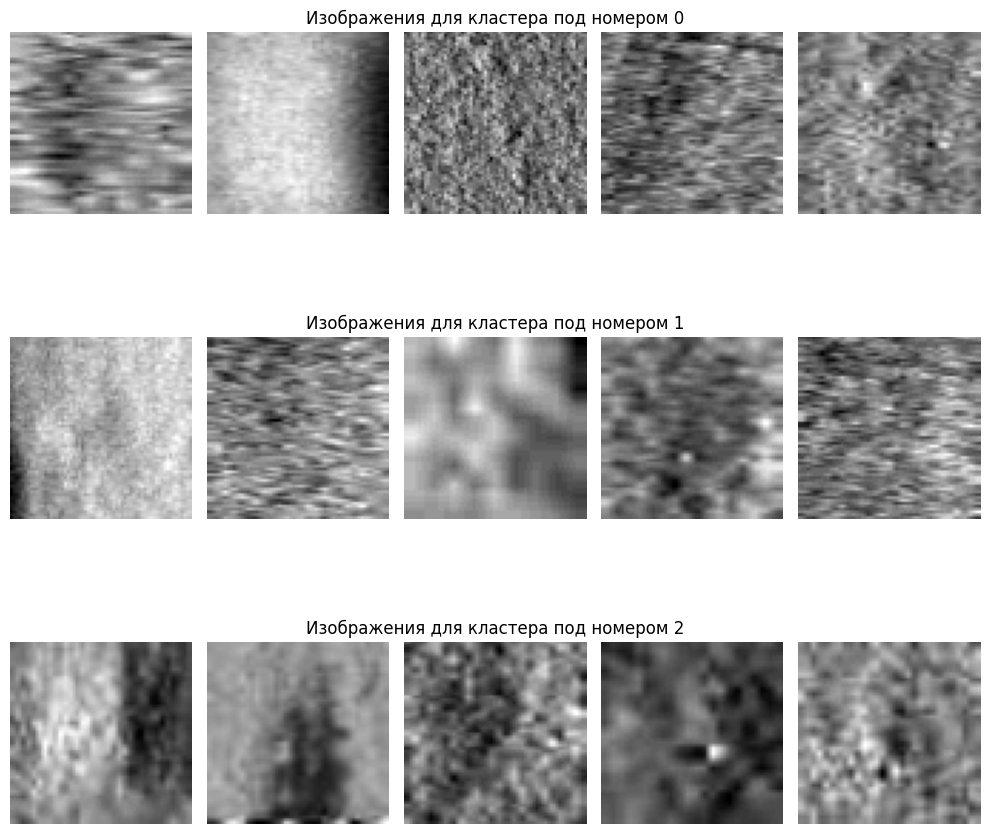

In [ ]:
n_clusters = 3

num_images_per_cluster = 5

fig, axis = plt.subplots(n_clusters, num_images_per_cluster, figsize = (10,10))

for cluster in range(n_clusters):
  cluster_indices = list(clustered_df[clustered_df['cluster_number'] == cluster].sample(5).index)

  #print(f'Изображения для кластера под номером {cluster}')
  for i, image_index in enumerate(cluster_indices):
    ax = axis[cluster, i]

    image_path = os.path.join(path, str(image_index)+ '.jpg')
    image = Image.open(image_path)
    image = new_data_transforms(image)


    ax.imshow(image.permute(1,2,0), cmap = 'gray')
    ax.axis('off')

  axis[cluster, 2].title.set_text(f'Изображения для кластера под номером {cluster}')
#plt.subtitle('В каждой строке изображения из одного кластера')
plt.tight_layout()

plt.show()

## Вывод:

Картинки плохо разбиваются на кластеры. Группы картинок, которые можно было бы выделить даже при беглом просмотре изображений не были выделены. Извлечение признаков с помощью AlexNet кажется более информативным. В пространстве сократилось число выбросов.

# Общий вывод

Нужно просмотреть все картинки вручную :)